**homework 24**

Instructions: Before starting this assignment, download cat_images.zip and cat_bounding_boxes.csv, and make sure they are in the same folder as your homework assignment. Then, unzip cat_images.zip (often by double-clicking on it).

We start by importing the necessary libraries, and setting the `device` variable appropriately.

In [2]:
!pip install pandas torch 

import torch, os, numpy as np
from torch import nn
from torch.optim import Adam
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt

device = ('cuda' if torch.cuda.is_available()
          else 'mps'  if torch.backends.mps.is_available()
          else 'cpu')
print('Using', device)


[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: C:\Users\Jeremy Tan\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Using cpu


Let's take a look at the data we'll be working with. The next code cell reads one image from the cat_images folder, and plots a bounding box over it's face. Bounding box data will be the target for our Neural Network, and is located in cat_bounding_boxes.csv.

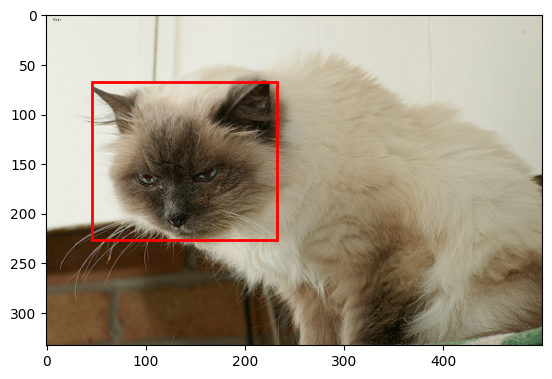

In [3]:
IMG_DIR = "cat_images"
CSV_PATH = "cat_bounding_boxes.csv"

df = pd.read_csv(CSV_PATH)
row = df.iloc[0]
img = Image.open(f"{IMG_DIR}/{row['filename']}")
plt.imshow(img)
plt.gca().add_patch(
    plt.Rectangle((row['xmin'], row['ymin']), row['xmax'] - row['xmin'], row['ymax'] - row['ymin'],
                  edgecolor='red', facecolor='none', linewidth=2)
)
plt.show()

We now process the data and turn it into pytorch tensors on `device` that we'll be able to train a NN with.

In [4]:
# Parameters
IMAGE_SIZE = (128, 128)  # Resize all images to this shape

# Load CSV
df = pd.read_csv(CSV_PATH)

# Preallocate arrays
num_images = len(df)
X = np.zeros((num_images, 3, IMAGE_SIZE[1], IMAGE_SIZE[0]), dtype=np.float32)  # Channels-first
y = np.zeros((num_images, 4), dtype=np.float32)  # Bounding boxes

# Load and preprocess images
for i, row in enumerate(df.itertuples()):
    path = os.path.join(IMG_DIR, row.filename)
    # Load original image
    img = Image.open(path).convert("RGB")
    orig_width, orig_height = img.size

    # Rescale bounding box
    xmin = row.xmin / orig_width
    ymin = row.ymin / orig_height
    xmax = row.xmax / orig_width
    ymax = row.ymax / orig_height
    y[i] = [xmin,ymin,xmax,ymax]

    # Resize image
    img = img.resize(IMAGE_SIZE)

    # Convert to NumPy and normalize to [0,1]
    img_np = np.asarray(img) / 255.0
    img_chw = np.transpose(img_np, (2, 0, 1))  # (H,W,C) → (C,H,W)
    X[i] = img_chw

#Normalize to (-1,1)
X = (X - 0.5) / 0.5

#Data Augmentation! Flip all images
X_aug = np.flip(X, axis=3).copy()                  # flip width dimension (C,H,W)
y_aug = y.copy()
y_aug[:, [0,2]] = 1.0 - y_aug[:, [2,0]]           # xmin ↔ xmax

X = np.concatenate([X, X_aug], axis=0)
y = np.concatenate([y, y_aug], axis=0)

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).to(device)
y_tensor = torch.from_numpy(y).to(device)


Next, we shuffle the data and set aside 80% for training and 20% for validation.

In [5]:
perm      = torch.randperm(num_images)
split     = int(0.8 * num_images)
train_ix  = perm[:split]
val_ix = perm[split:]

X_train   = X_tensor[train_ix]
y_train = y_tensor[train_ix]
X_val     = X_tensor[val_ix]
y_val   = y_tensor[val_ix]

Now, define a CNN to predict bounding box information.

*Hint: You can signifcantly reduce the number of parameters by using a layer like `nn.AdaptiveAvgPool2d(1)` just before your Flatten layer. This results in a 1x1 image per channel, so the size of the input to your first Linear layer will simply be the number of channels produced by your last Conv2d layer.

In [6]:
model=nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d(1),  # Output shape: (128, 1, 1)

            nn.Flatten(),             # Shape: (batch_size, 128)
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 4)          # Output: (xmin, ymin, xmax, ymax)
        )

In [7]:
optimizer=Adam(model.parameters(), lr=1e-3)

Now run the following training loop. Train for at least 200 epochs. (On a 2020 Intel Macbook Pro 200 epochs took < 10 min.)

The code is almost identical to what we've seen before, with a few minor changes:
1. Note the suggested loss function.
2. Seperate training and validation loss tracking

In [8]:
n_epochs=200
N = X_train.shape[0]  # total number of observations in training data
batch_size=32

#loss_fn = nn.MSELoss() #This would work
loss_fn = nn.SmoothL1Loss(beta=1/9) #Seems to work better

for epoch in range(n_epochs):
  model.train()
  epoch_loss = 0.0
  num_batches = 0

  # Shuffle the indices
  indices = torch.randperm(N,device=device)

  # Create mini-batches
  for i in range(0, N, batch_size):
    batch_indices = indices[i:i+batch_size]
    batch_X = X_train[batch_indices]
    batch_y = y_train[batch_indices]

    optimizer.zero_grad()
    loss=loss_fn(model(batch_X),batch_y)
    loss.backward()
    optimizer.step()

    epoch_loss += loss.item() #Accumulate mini-batch losses througout epoch
    num_batches += 1

  if epoch%2==0:
      model.eval()
      train_loss = epoch_loss / num_batches #Compute avg training loss
      with torch.no_grad():
          val_loss=loss_fn(model(X_val),y_val).item()
      print(f"epoch: {epoch}, train_loss: {train_loss}, val_loss: {val_loss}")

epoch: 0, train_loss: 0.15503476336598396, val_loss: 0.08742374181747437
epoch: 2, train_loss: 0.0801454283297062, val_loss: 0.07723402231931686
epoch: 4, train_loss: 0.07782147079706192, val_loss: 0.07831808924674988
epoch: 6, train_loss: 0.07998404614627361, val_loss: 0.07717647403478622
epoch: 8, train_loss: 0.07884994894266129, val_loss: 0.08071964234113693
epoch: 10, train_loss: 0.07894908785820007, val_loss: 0.09259164333343506
epoch: 12, train_loss: 0.07587941400706769, val_loss: 0.07475392520427704
epoch: 14, train_loss: 0.07513404674828053, val_loss: 0.07596763968467712
epoch: 16, train_loss: 0.07540236078202725, val_loss: 0.07585273683071136
epoch: 18, train_loss: 0.0757442381232977, val_loss: 0.0808023065328598
epoch: 20, train_loss: 0.07611722871661186, val_loss: 0.07617668807506561
epoch: 22, train_loss: 0.07409066185355187, val_loss: 0.07576031982898712
epoch: 24, train_loss: 0.07437425069510936, val_loss: 0.07704988867044449
epoch: 26, train_loss: 0.07473022807389498, va

Now run this code block to see how your trained model did on a few images from the validation set.

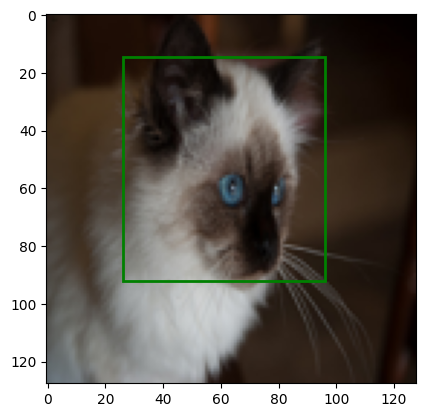

: 

In [ ]:
image_num=3 #Change this to check different images

model.eval()
pred=model(X_val[image_num:image_num+1]).cpu().detach().numpy()
xmin,ymin,xmax,ymax=pred[0]
xmin*=IMAGE_SIZE[0]
xmax*=IMAGE_SIZE[0]
ymin*=IMAGE_SIZE[1]
ymax*=IMAGE_SIZE[1]

img = X_val[image_num].cpu()
img = img * 0.5 + 0.5
img = img.permute(1, 2, 0).numpy()     # C,H,W → H,W,C

plt.imshow(img)
plt.gca().add_patch(
    plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin,
                  edgecolor='green', facecolor='none', linewidth=2)
)

Take a screen shot and upload to gradescope!